# Processing from Bender et al.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

GRAVITY = 9.81

In [2]:
PERCENT_SHOWN = .01 # Percentage of data shown in graphs
SAMPLING_FREQ = 4 # Hz

#### Read in Data  

In [3]:
df = pd.read_csv('sim_imu_data.csv')

# some variables for future use
n_samples = len(df["Az (m/s^2)"])
time_domain = np.arange(0, n_samples * (1 / SAMPLING_FREQ), 1 / SAMPLING_FREQ)
data_shown = int(len(df["Az (m/s^2)"]) * PERCENT_SHOWN) 

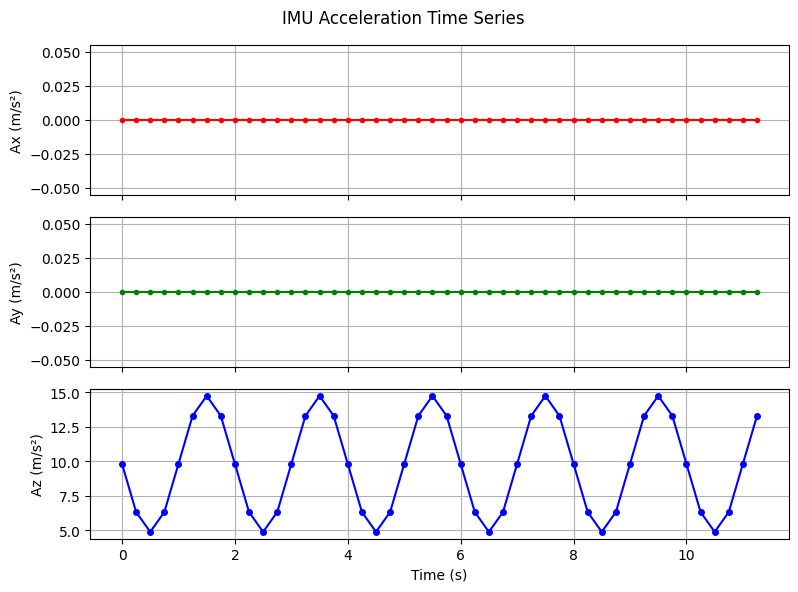

In [4]:
# Plot each acceleration component separately
fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

axes[0].plot(time_domain[0:data_shown], df["Ax (m/s^2)"][0:data_shown], label="Ax (m/s²)", marker='o', markersize=3,color='r')
axes[1].plot(time_domain[0:data_shown],df["Ay (m/s^2)"][0:data_shown], label="Ay (m/s²)", marker='o', markersize=3, color='g')
axes[2].plot(time_domain[0:data_shown],df["Az (m/s^2)"][0:data_shown], label="Az (m/s²)", marker='o', markersize=4, color='b')

# Labels and formatting
for ax in axes:
    ax.grid(True)

axes[2].set_xlabel("Time (s)")
axes[0].set_ylabel("Ax (m/s²)")
axes[1].set_ylabel("Ay (m/s²)")
axes[2].set_ylabel("Az (m/s²)")

plt.suptitle("IMU Acceleration Time Series")
plt.tight_layout()
plt.show()

#### 1) Tilt Correction - Method IV, equation 8 

In [5]:
vert_acc = (GRAVITY - np.sqrt(df['Az (m/s^2)']**2 + 
                                                      df['Ay (m/s^2)']**2 + 
                                                      df['Ax (m/s^2)']**2)).to_numpy()

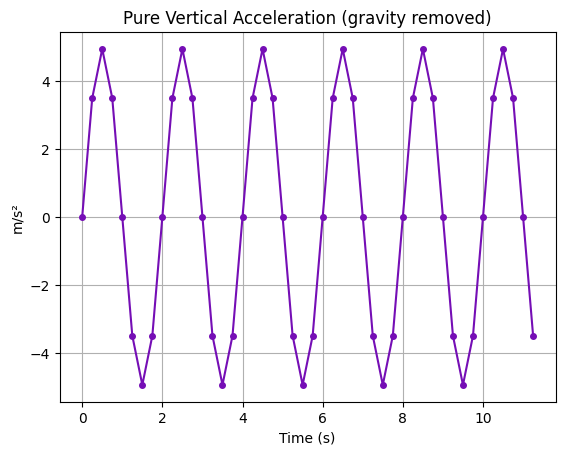

In [6]:
plt.plot(time_domain[0:data_shown], vert_acc[0:data_shown], marker='o',markersize=4, color='#750eb5')
plt.xlabel('Time (s)')
plt.grid(True)
plt.ylabel('m/s²')
plt.title('Pure Vertical Acceleration (gravity removed)')
plt.show()

#### 2) Time Synchronization
###### not needed here

#### 3) Filtering 
##### Linearly Detrend the Vertical Accelerations

In [7]:
# # Create an index array (1-based index)
# indices = np.arange(1, n_samples + 1)

# # Compute sumX, sumY, sumXY, sumXX using NumPy operations
# sumX = np.sum(indices)
# sumY = np.sum(vert_acc)
# sumXY = np.sum(indices * vert_acc)
# sumXX = np.sum(indices ** 2)

# # Compute slope and intercept
# slope = (n_samples * sumXY - sumX * sumY) / (n_samples * sumXX - sumX ** 2)
# intercept = (sumY - slope * sumX) / n_samples

# # Update y values
# print(vert_acc[0:data_shown])
# vert_acc -= (slope * indices + intercept)
# print(vert_acc[0:data_shown])

[ 3.0000000e-03  3.4924321e+00  4.9378022e+00  3.4924321e+00
  3.0000000e-03 -3.4864321e+00 -4.9318022e+00 -3.4864321e+00
  3.0000000e-03  3.4924321e+00  4.9378022e+00  3.4924321e+00
  3.0000000e-03 -3.4864321e+00 -4.9318022e+00 -3.4864321e+00
  3.0000000e-03  3.4924321e+00  4.9378022e+00  3.4924321e+00
  3.0000000e-03 -3.4864321e+00 -4.9318022e+00 -3.4864321e+00
  3.0000000e-03  3.4924321e+00  4.9378022e+00  3.4924321e+00
  3.0000000e-03 -3.4864321e+00 -4.9318022e+00 -3.4864321e+00
  3.0000000e-03  3.4924321e+00  4.9378022e+00  3.4924321e+00
  3.0000000e-03 -3.4864321e+00 -4.9318022e+00 -3.4864321e+00
  3.0000000e-03  3.4924321e+00  4.9378022e+00  3.4924321e+00
  3.0000000e-03 -3.4864321e+00]
[-0.00775461  3.48168086  4.92705432  3.48168759 -0.00774114 -3.49716988
 -4.94253661 -3.49716315 -0.00772768  3.48170779  4.92708125  3.48171452
 -0.00771421 -3.49714295 -4.94250968 -3.49713621 -0.00770075  3.48173472
  4.92710819  3.48174145 -0.00768728 -3.49711601 -4.94248275 -3.49710928
 -0.0

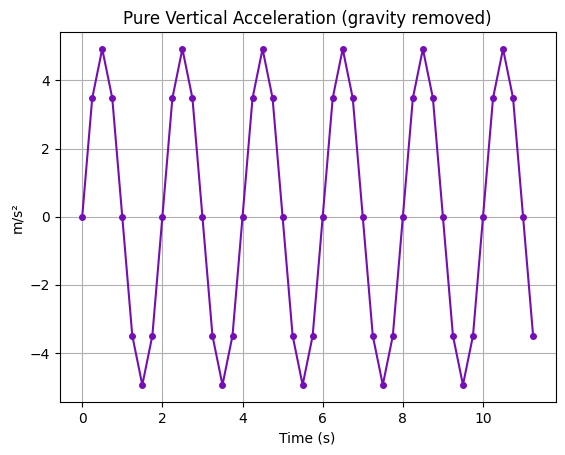

In [8]:
plt.plot(time_domain[0:data_shown], vert_acc[0:data_shown], marker='o',markersize=4, color='#750eb5')
plt.xlabel('Time (s)')
plt.grid(True)
plt.ylabel('m/s²')
plt.title('Pure Vertical Acceleration (gravity removed)')
plt.show()

##### Remove Outliers + Use Cubic Spline to Interpolate

In [9]:
from scipy.interpolate import CubicSpline

mean = np.mean(vert_acc)
std_dev = np.std(vert_acc)

outlier_indices = np.where(np.abs(vert_acc - mean) > 3 * std_dev)[0]    

# Create valid indices
valid_indices = np.arange(n_samples)
valid_indices = np.delete(valid_indices, outlier_indices)
        
#Sort the valid indices
valid_indices_sorted = np.sort(valid_indices)

# Perform cubic spline interpolation on valid data
cs = CubicSpline(valid_indices_sorted, vert_acc[valid_indices_sorted])

# Interpolate missing values                     
interpolated_values = cs(outlier_indices)

# Replace interpolated values in the original list
for i, index in enumerate(outlier_indices):
    vert_acc[index] = interpolated_values[i]

##### Kalman Filter

#### 4) Acceleration Spectra 
##### Break Data into Segments

In [10]:
overlap_percent = 0.5
non_overlap_percent = 1-overlap_percent
N_SEGMENTS = 17

non_overlap_size = int(n_samples // (N_SEGMENTS + overlap_percent / non_overlap_percent))
overlap_size = int(overlap_percent * non_overlap_size / non_overlap_percent)

segment_size = int(non_overlap_size * (1+overlap_percent/(1-overlap_percent)))

print("overlap size", overlap_size)
print("non-overlap size", non_overlap_size)
print("segment size", segment_size)

segments = []
for i in range(0, n_samples, non_overlap_size):
    if i+segment_size <= n_samples:
        segments.append(vert_acc[i:i+segment_size])

print("Segments count", len(segments))
print(list(map(len, segments)))

overlap size 256
non-overlap size 256
segment size 512
Segments count 17
[512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512]


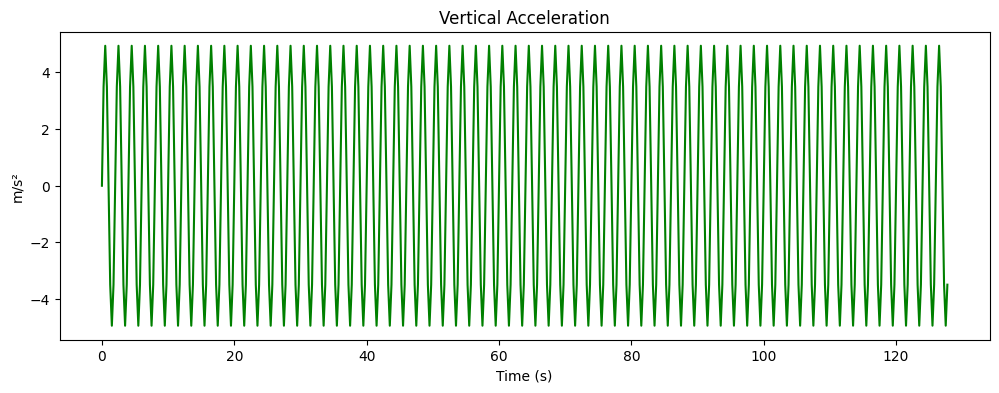

In [11]:
plt.figure(figsize=(12, 4))  # Adjust width and height (12 inches wide, 4 inches tall)
plt.plot(time_domain[0:segment_size], segments[5], color='g')
plt.xlabel('Time (s)')
plt.ylabel('m/s²')
plt.title('Vertical Acceleration')
plt.show()

##### Apply Kaiser-Bessel Window

In [12]:
from scipy import signal
BETA = .5

# window = signal.windows.kaiser(segment_size, beta = BETA, sym = True)
# segments *= window

##### FFT Windowed Segments

In [13]:
# 1) Compute the FFT of each windowed segment (one-sided for real input)
fft_segments = np.fft.rfft(segments)

# 2) Magnitude squared
power_acc_spectrum = np.abs(fft_segments)**2

# 3) Multiply interior bins by 2
power_acc_spectrum[:, 1:-1] *= 2.0

# 4) Divide by (N * fs * sum_of_window_squares)
power_acc_spectrum /= (segment_size * SAMPLING_FREQ)# * np.sum(window**2))

#5) Avereage the segments
power_acc_spectrum = np.mean(power_acc_spectrum, axis=0)

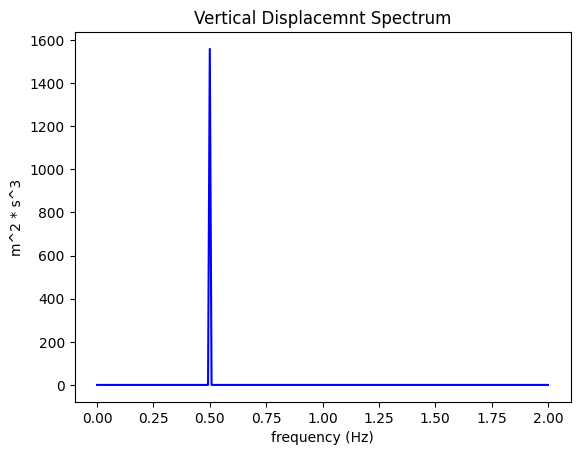

In [14]:
freq_domain = np.fft.rfftfreq(segment_size, d=1.0/SAMPLING_FREQ)

plt.plot(freq_domain ,power_acc_spectrum, color='b')
plt.xlabel('frequency (Hz)')  # Replace 'X-axis Label' with your desired label for the x-axis
plt.ylabel('m^2 * s^3')
plt.title('Vertical Displacemnt Spectrum')
plt.show()

#### 5) Filtering 

In [15]:
# noise. We utilized a modification of the empirical noise
# correction of Lang (1987), which establishes a noise estimate
# and then removes that noise in a linearly decreasing
# manner between a lower (0.05 Hz) and upper
# (0.15 Hz) frequency.

# We determined the noise estimate
# to be the product of the mean spectral density between
# 0.01 and 0.05 Hz and the slope of the noise correction
# factor Snc to be 20



#### 6) Displacement Spectra

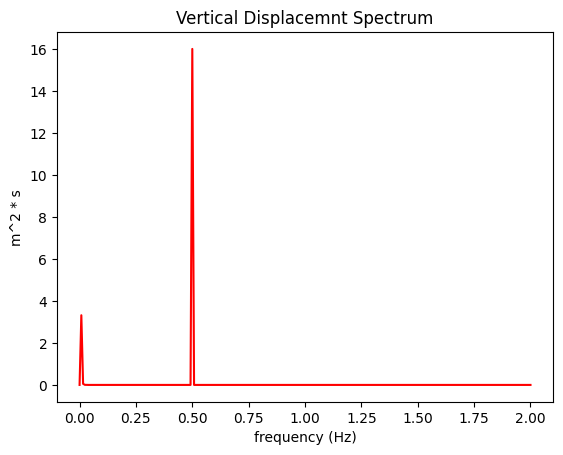

In [16]:
# Avoid division by zero by setting the first index to a safe value
d_spectrum = np.zeros_like(power_acc_spectrum, dtype=float)  # Initialize result array
nonzero_mask = freq_domain != 0  # Mask to avoid division by zero

# Perform division only where freq_domain is non-zero
d_spectrum[nonzero_mask] = power_acc_spectrum[nonzero_mask] / (freq_domain[nonzero_mask] * 2 * np.pi)**4

plt.plot(freq_domain ,d_spectrum, color='r')
plt.xlabel('frequency (Hz)')  # Replace 'X-axis Label' with your desired label for the x-axis
plt.ylabel('m^2 * s')
plt.title('Vertical Displacemnt Spectrum')
plt.show()

##### Spectral Moments

In [17]:
def get_spectral_moment(m: int):
    summy = 0
    for i in range(1, len(freq_domain)):
        summy += freq_domain[i] ** m * d_spectrum[i] * (freq_domain[1]-freq_domain[0])
    return summy
        
#Significant wave height, HM0, is approximately equal to the average of the highest one-third of the waves, 
# as measured from the trough to the crest of the waves.
HM0 = 4 * np.sqrt(get_spectral_moment(0))
print(HM0)


#energy period
TE = np.sqrt(get_spectral_moment(0) / get_spectral_moment(2))
print(TE)

#mean wave period 
AWP = get_spectral_moment(-1) / get_spectral_moment(0)
print(AWP)

1.5562614067129072
2.2008293121598697
23.754777787902288


In [18]:
# 1.4142135623730947